In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import ParameterGrid
from keras.utils import image_utils
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import pickle
import cv2
import os

Principal Component Analysis to reduce dimensions of the dataset

In [2]:
# Reading the dataset and dropping filename column
df = pd.read_csv("C:\\Personal\\h-and-m-personalized-fashion-recommendations\\vgg16.csv")
filenames = list(df["image_filename"])
df = df.drop("image_filename",axis=1)
new_df = df.copy()
df.shape

(105100, 4096)

In [3]:
# Scaling the features
scaler = StandardScaler()
df = scaler.fit_transform(df)

In [4]:
# Fitting and transforming PCA
pca = PCA()
df = pca.fit_transform(df)
cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

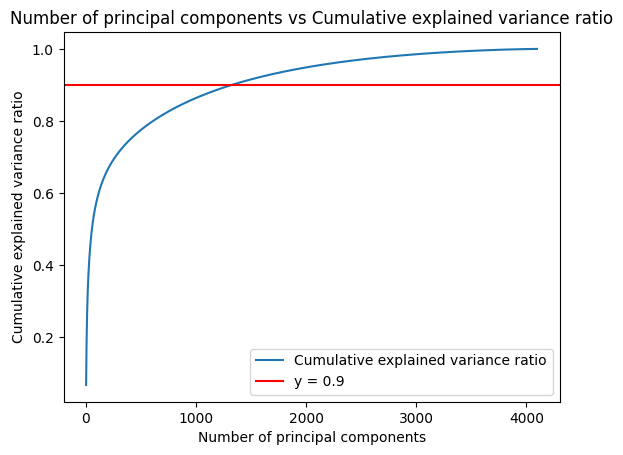

In [7]:
# Plotting cumulative explained variance ratio vs number of principal components
x = np.arange(start = 1,stop = len(cumulative_explained_variance_ratio)+1,step=1)
plt.plot(x,cumulative_explained_variance_ratio, label = 'Cumulative explained variance ratio')
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance ratio")
plt.title("Number of principal components vs Cumulative explained variance ratio")
plt.axhline(y = 0.9, color = 'r', linestyle = '-', label = 'y = 0.9')
plt.legend(loc = 'lower right')

In [6]:
# Finding number of principal components required for explaining 90% variance
difference_array = np.absolute(cumulative_explained_variance_ratio-0.9)
index = difference_array.argmin()
number_of_components = index+1
print(f"Number of principal components for explaining 90% variance in data : {number_of_components}")

Number of principal components for explaining 90% variance in data : 1322


In [7]:
# Reducing dimensions of dataset from 4096 to 1322
new_df = scaler.fit_transform(new_df)
pca = PCA(n_components=number_of_components)
new_df = pca.fit_transform(new_df)

In [13]:
#np.save('vgg16_pca.npy',new_df)

In [14]:
#with open('filenames.json', 'w') as file:
#    json.dump(filenames, file, indent=2)

KMeans Clustering to cluster similar images together

In [15]:
# Getting the best number of clusters based on silhoutte score
parameters = np.arange(start=50,stop=1000,step=50)
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()
silhouette_scores = []
for p in parameter_grid:
    kmeans_model.set_params(**p)    
    kmeans_model.fit(new_df)          
    ss = silhouette_score(new_df, kmeans_model.labels_)   
    silhouette_scores += [ss]     
    print(f"For n_clusters = {p['n_clusters']}, silhouette score is {ss}")
    if ss > best_score:
        best_score = ss
        best_n_cluster = p['n_clusters']
print(f"Best silhouette score is {best_score} for n_cluster = {best_n_cluster}")

For n_clusters = 50, silhouette score is -0.0012409375778466216
For n_clusters = 100, silhouette score is 5.030223639559706e-05
For n_clusters = 150, silhouette score is -0.005384850830561405
For n_clusters = 200, silhouette score is -0.0041844943872826204
For n_clusters = 250, silhouette score is -0.003356832426534538
For n_clusters = 300, silhouette score is -0.004292686123463466
For n_clusters = 350, silhouette score is -0.003223270119982792
For n_clusters = 400, silhouette score is -0.0020492608922808306
For n_clusters = 450, silhouette score is -0.0032072144412895473
For n_clusters = 500, silhouette score is -0.0006356614803605512
For n_clusters = 550, silhouette score is -0.00011209258308123004
For n_clusters = 600, silhouette score is -0.0014860593100181883
For n_clusters = 650, silhouette score is -0.0011305385551369134
For n_clusters = 700, silhouette score is -0.00039829565051390366
For n_clusters = 750, silhouette score is -0.000549691425696405
For n_clusters = 800, silhouet

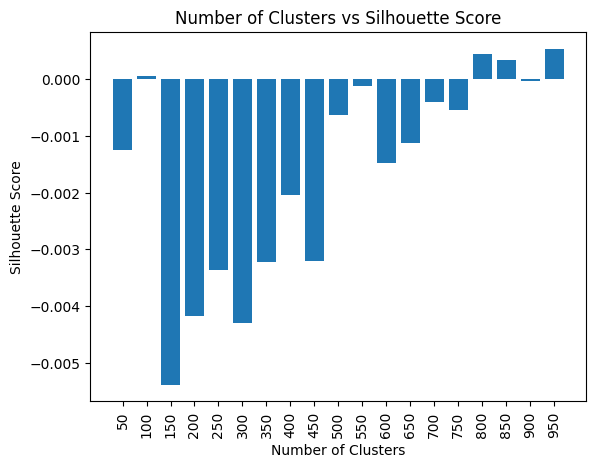

In [20]:
# Visualizing the results from different values of n_clusters
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center')
plt.xticks(range(len(silhouette_scores)), list(parameters),rotation=90)
plt.title('Number of Clusters vs Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [9]:
# Using the best Kmeans model
kmeans_best_model = KMeans(n_clusters=best_n_cluster)
kmeans_best_model.fit(new_df)

KMeans(n_clusters=950)

In [10]:
# Storing clusters
cluster_data = {}
for file, cluster in zip(filenames,kmeans_best_model.labels_):
    if cluster not in cluster_data.keys():
        cluster_data[cluster] = []
        cluster_data[cluster].append(str(0)+str(file)+'.jpg')
    else:
        cluster_data[cluster].append(str(0)+str(file)+'.jpg')

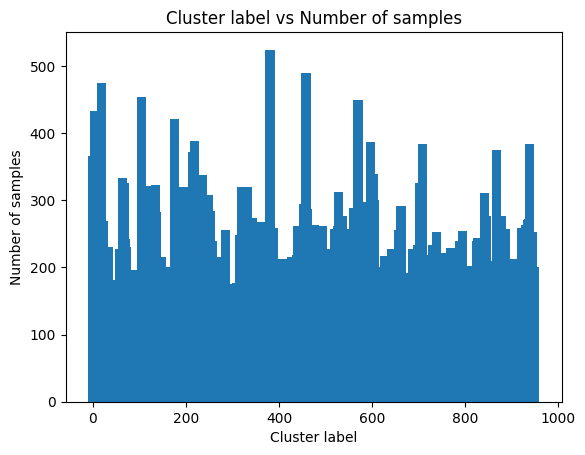

In [11]:
# Plotting number of samples in each cluster
hist_x = cluster_data.keys()
hist_y = []
for cluster_label in cluster_data.keys():
    hist_y += [len(cluster_data[cluster_label])]

plt.bar(hist_x, hist_y, align='center',width=20)
plt.title('Cluster label vs Number of samples')
plt.xlabel('Cluster label')
plt.ylabel('Number of samples')
plt.show()

In [24]:
# Function to get image path from image name
def get_image_path(image_name):
    sub_folder_name = image_name.split(".")[0][0:3]
    images_folder_path = "C:\\Personal\\h-and-m-personalized-fashion-recommendations\\h-and-m-personalized-fashion-recommendations\\images"
    image_path = os.path.join(images_folder_path,sub_folder_name,image_name)
    return image_path

In [40]:
# Function to visualize any cluster with maximum number of samples you want to visualize
def visualize_cluster(cluster_label,max_num_samples):
    i=0
    fig = plt.figure(figsize=(20,20))
    plt.axis('off')
    plt.title(f"Cluster {cluster_label} samples")
    cluster_samples = cluster_data[cluster_label]
    while i < len(cluster_samples) and i < max_num_samples: 
        fig.add_subplot(10, 10, i+1)
        plt.imshow(cv2.imread(get_image_path(cluster_samples[i])))
        plt.axis('off')
        i+=1

Lets visualize a few clusters

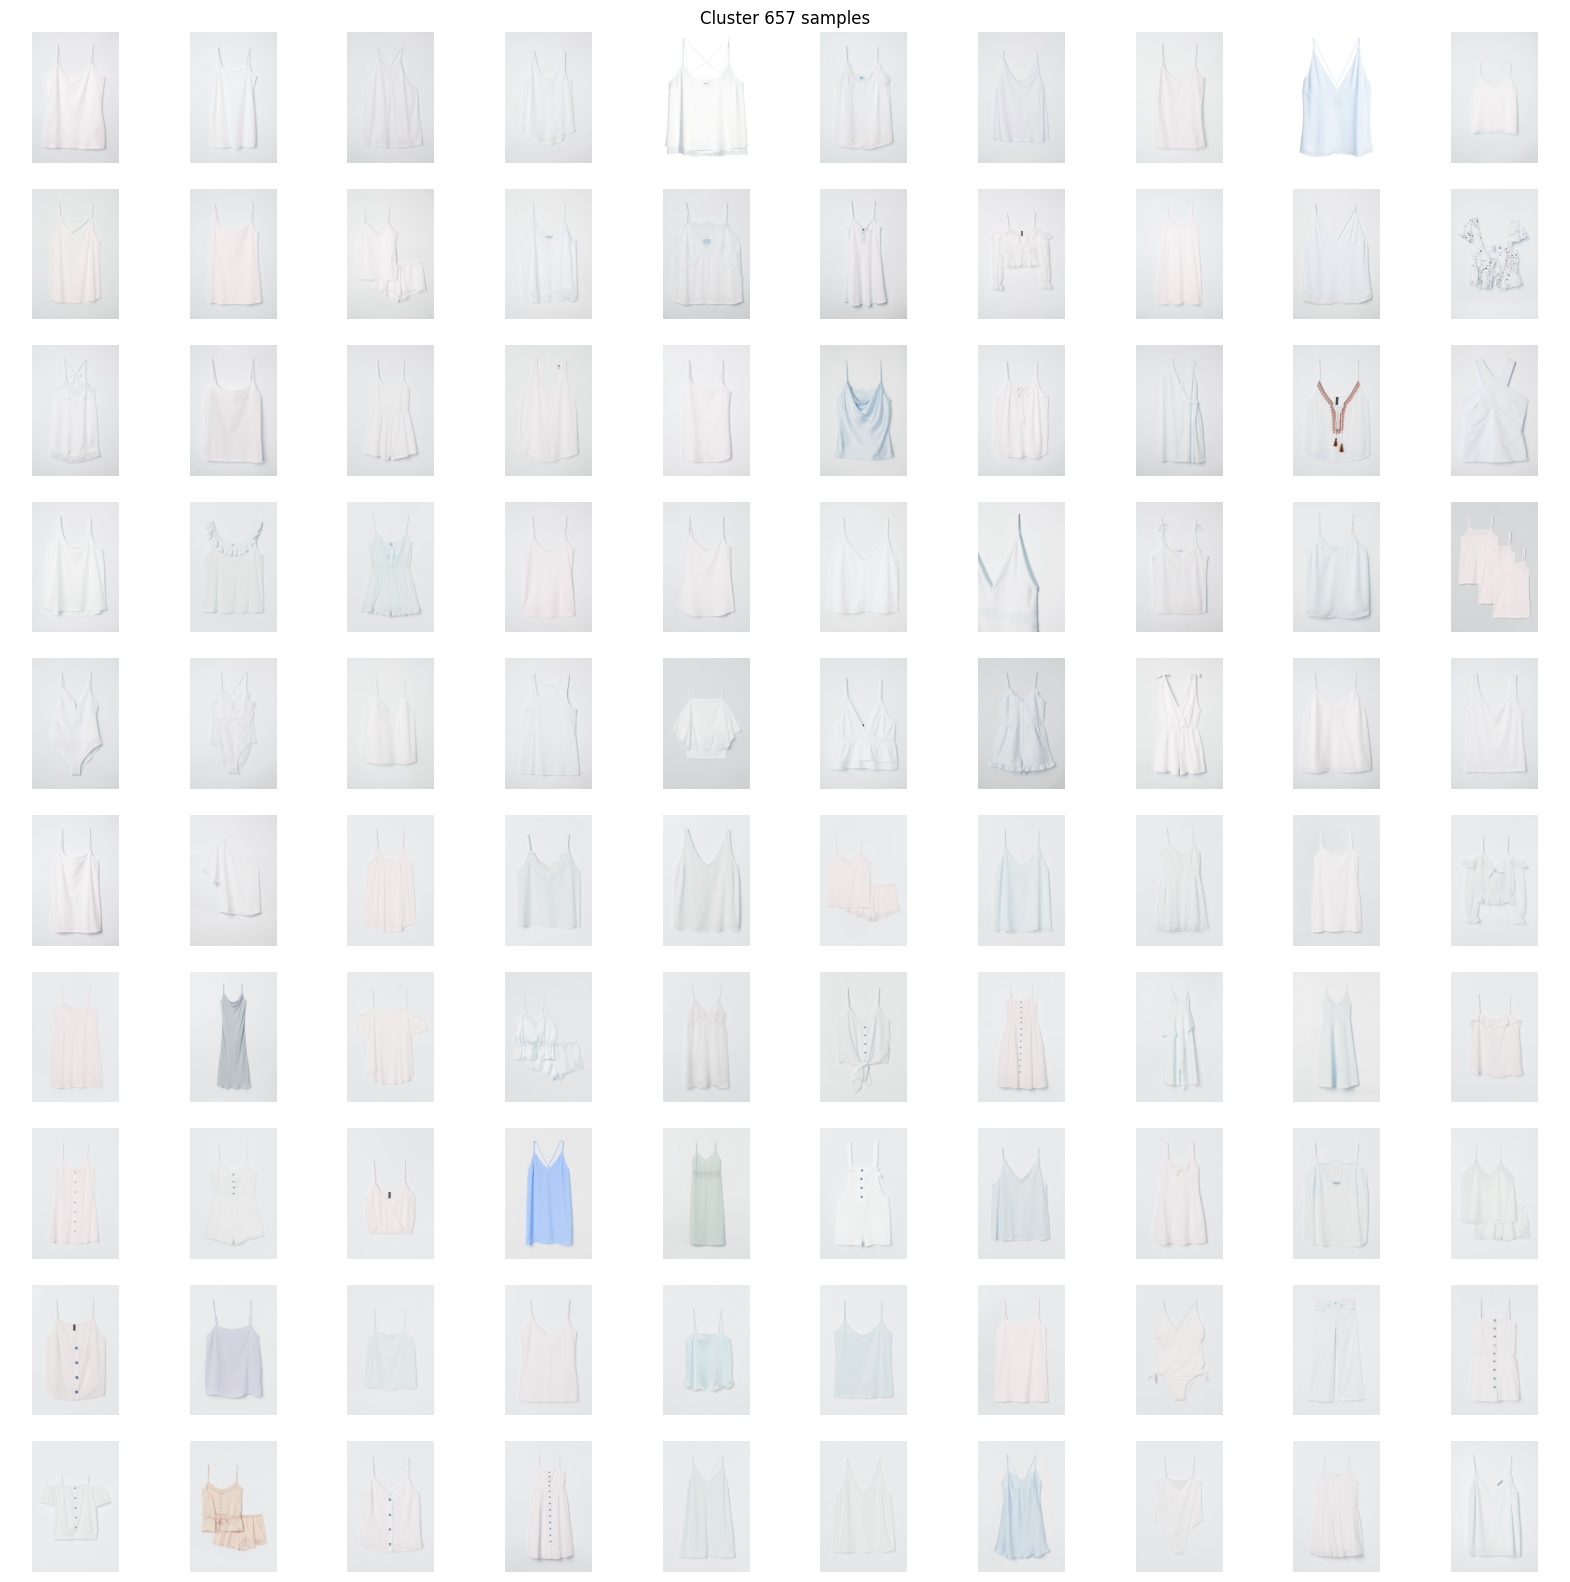

In [42]:
visualize_cluster(657,100)

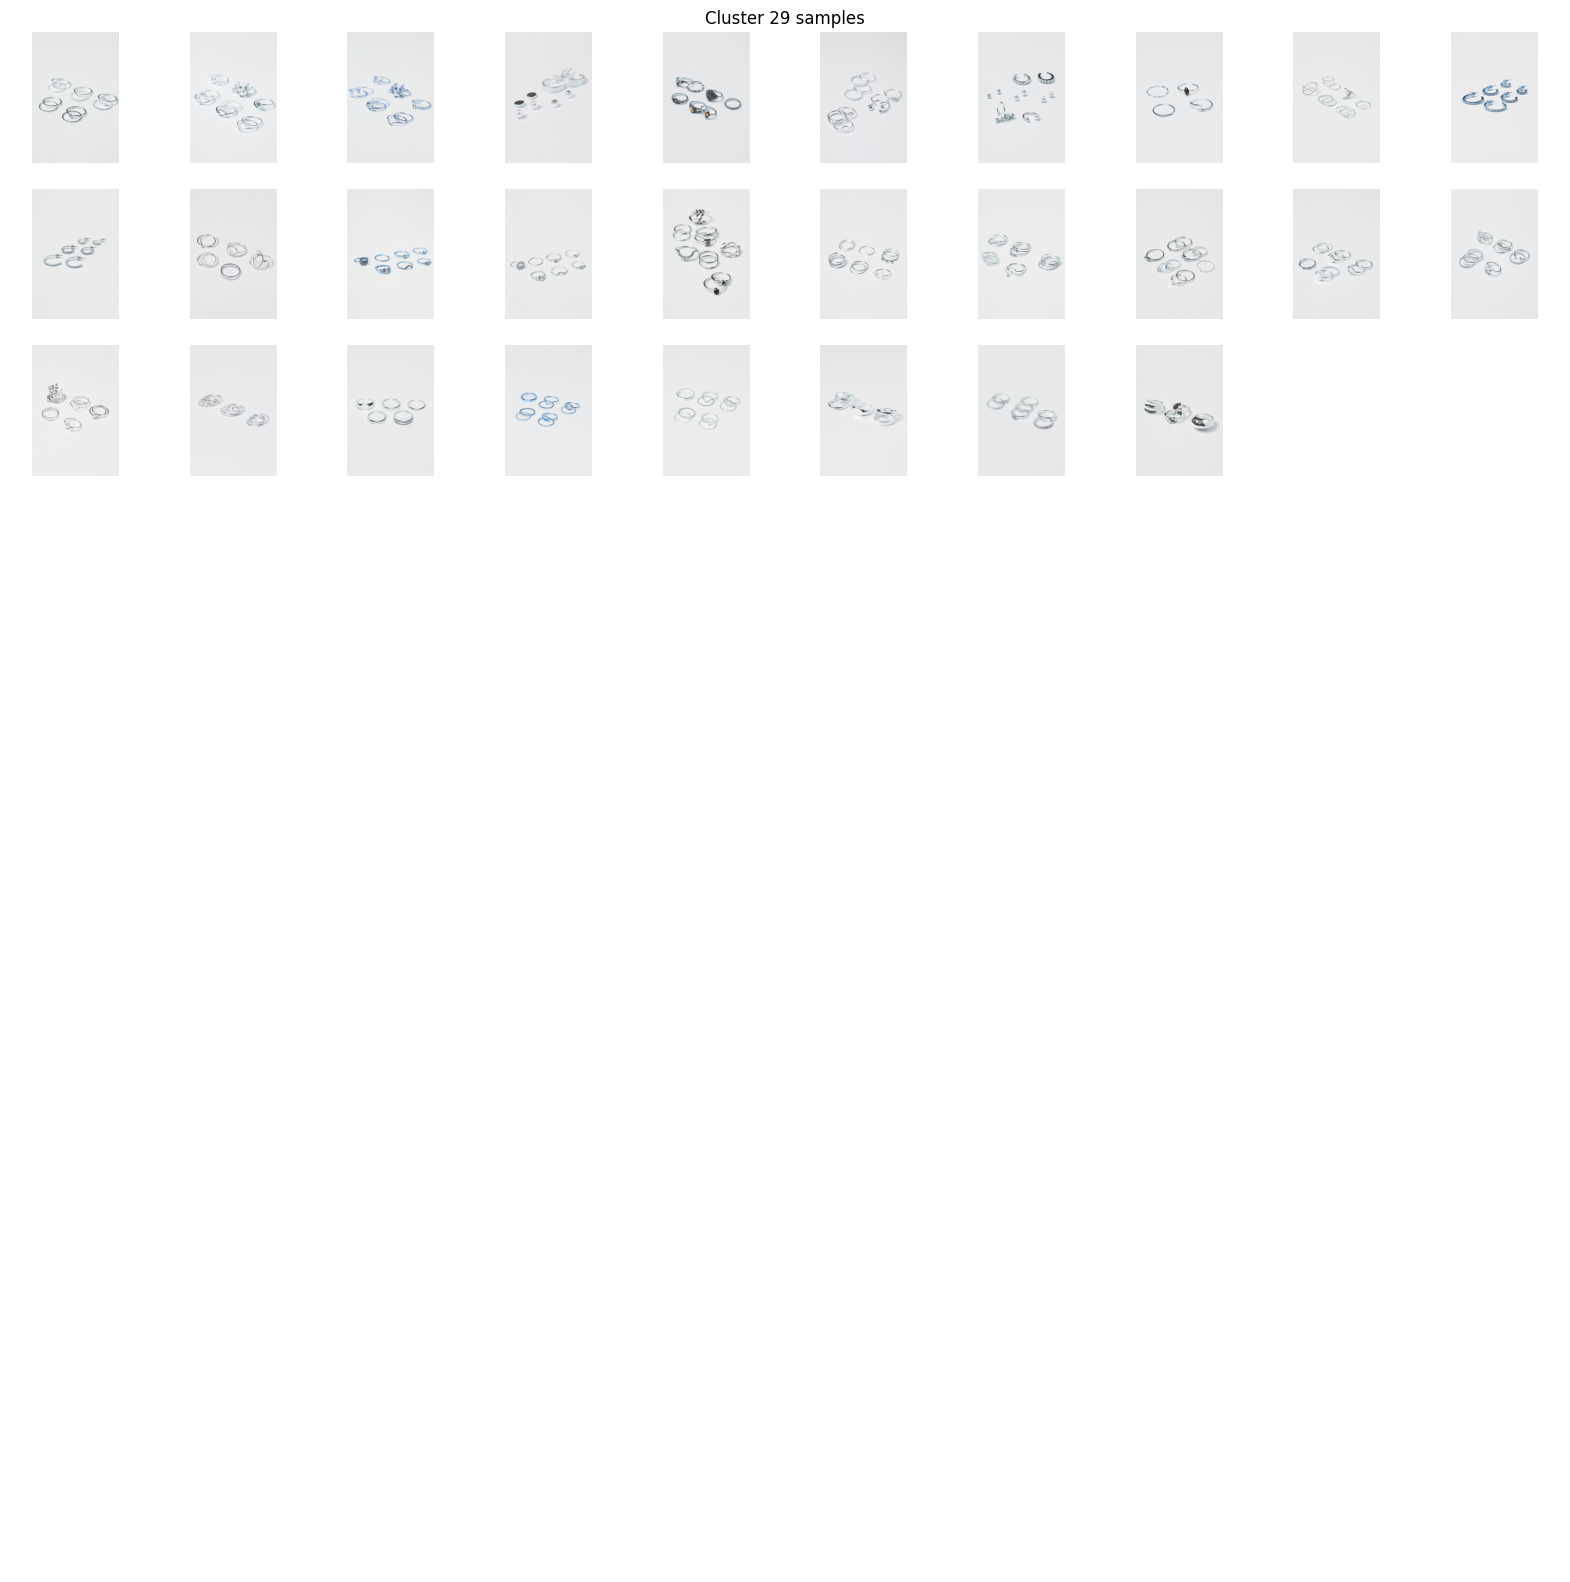

In [43]:
visualize_cluster(29,100)

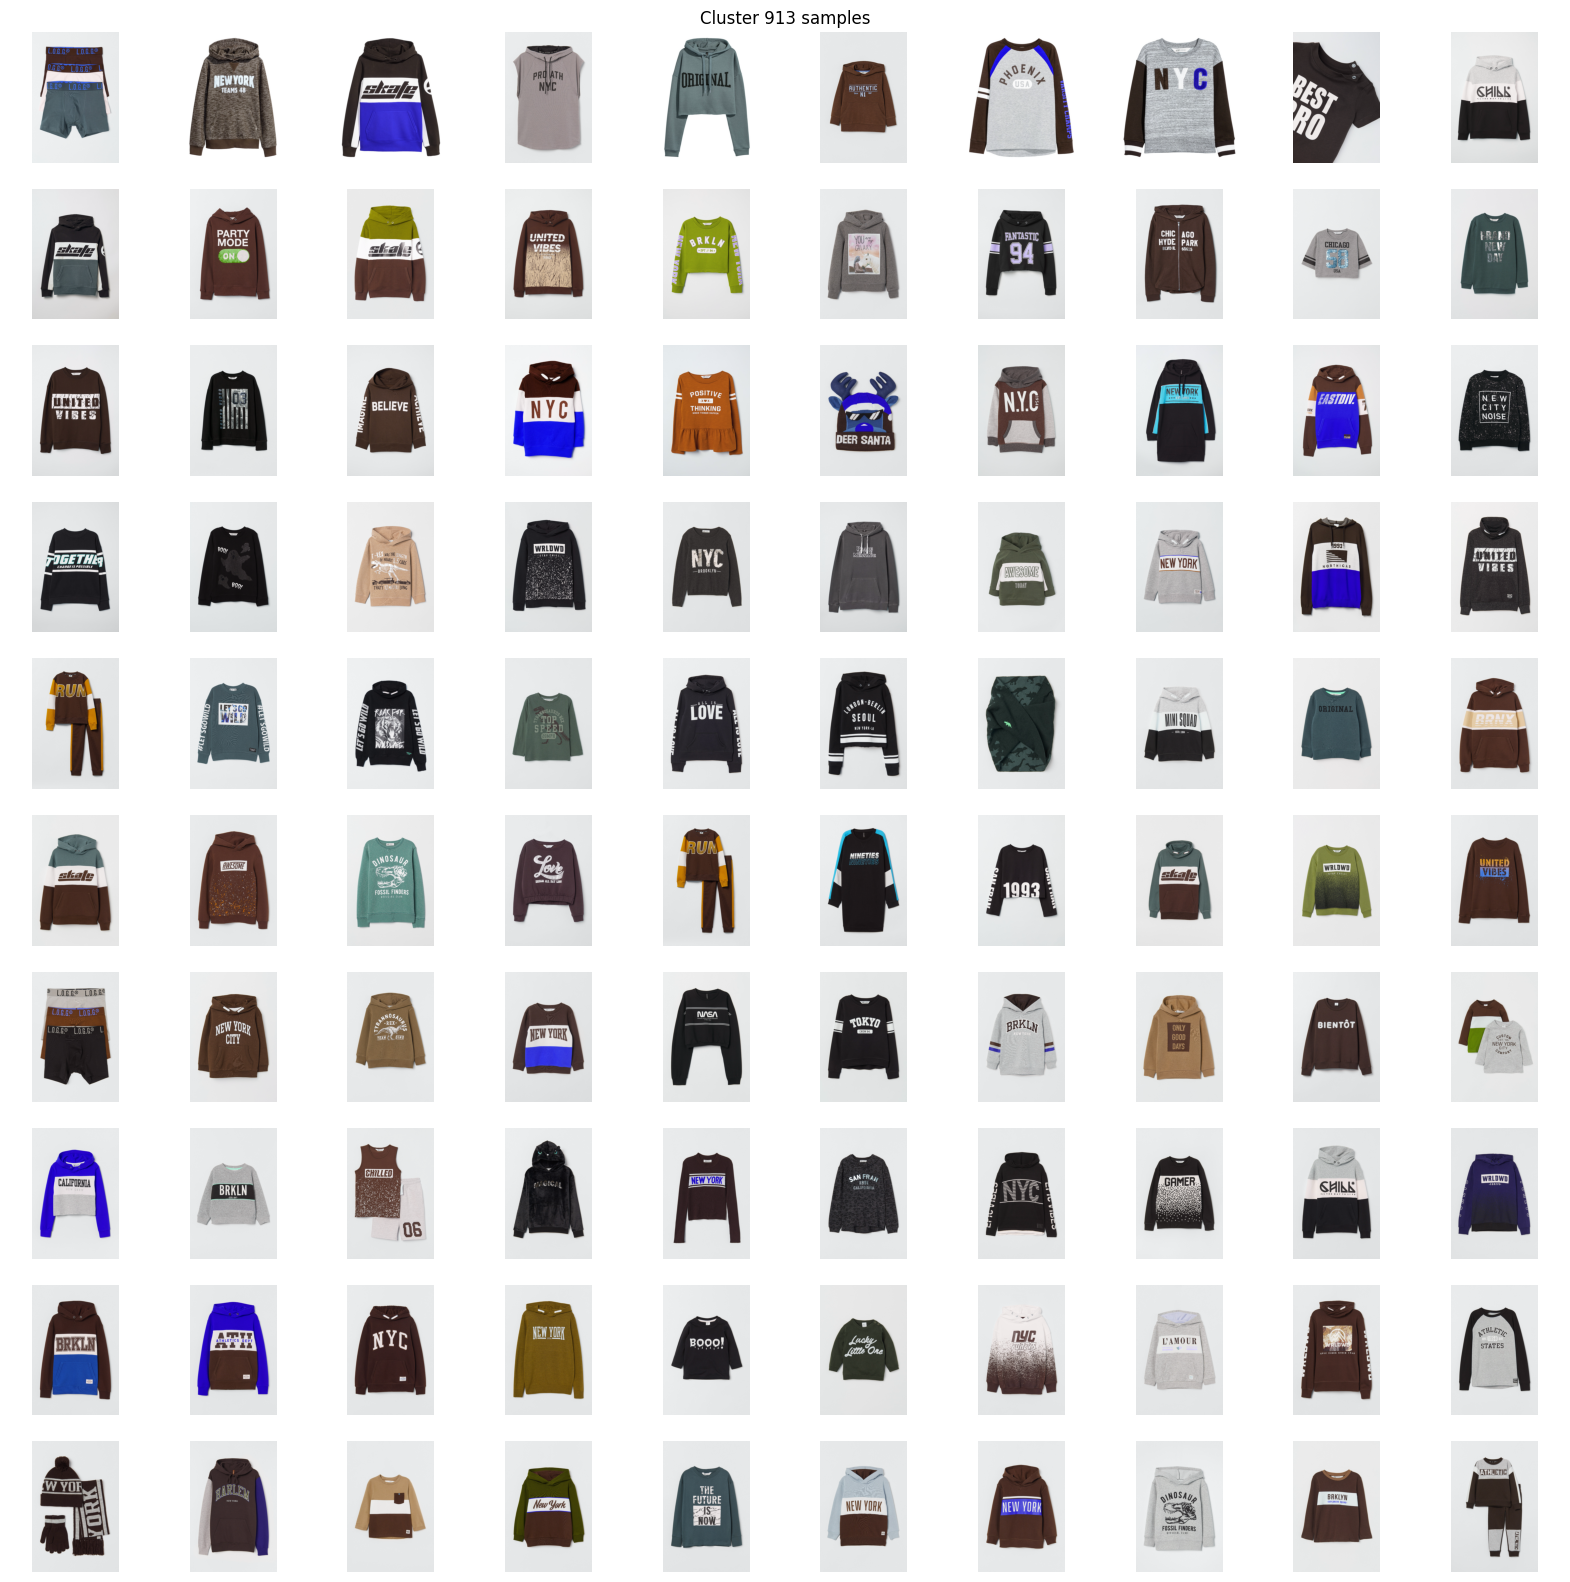

In [47]:
visualize_cluster(913,100)

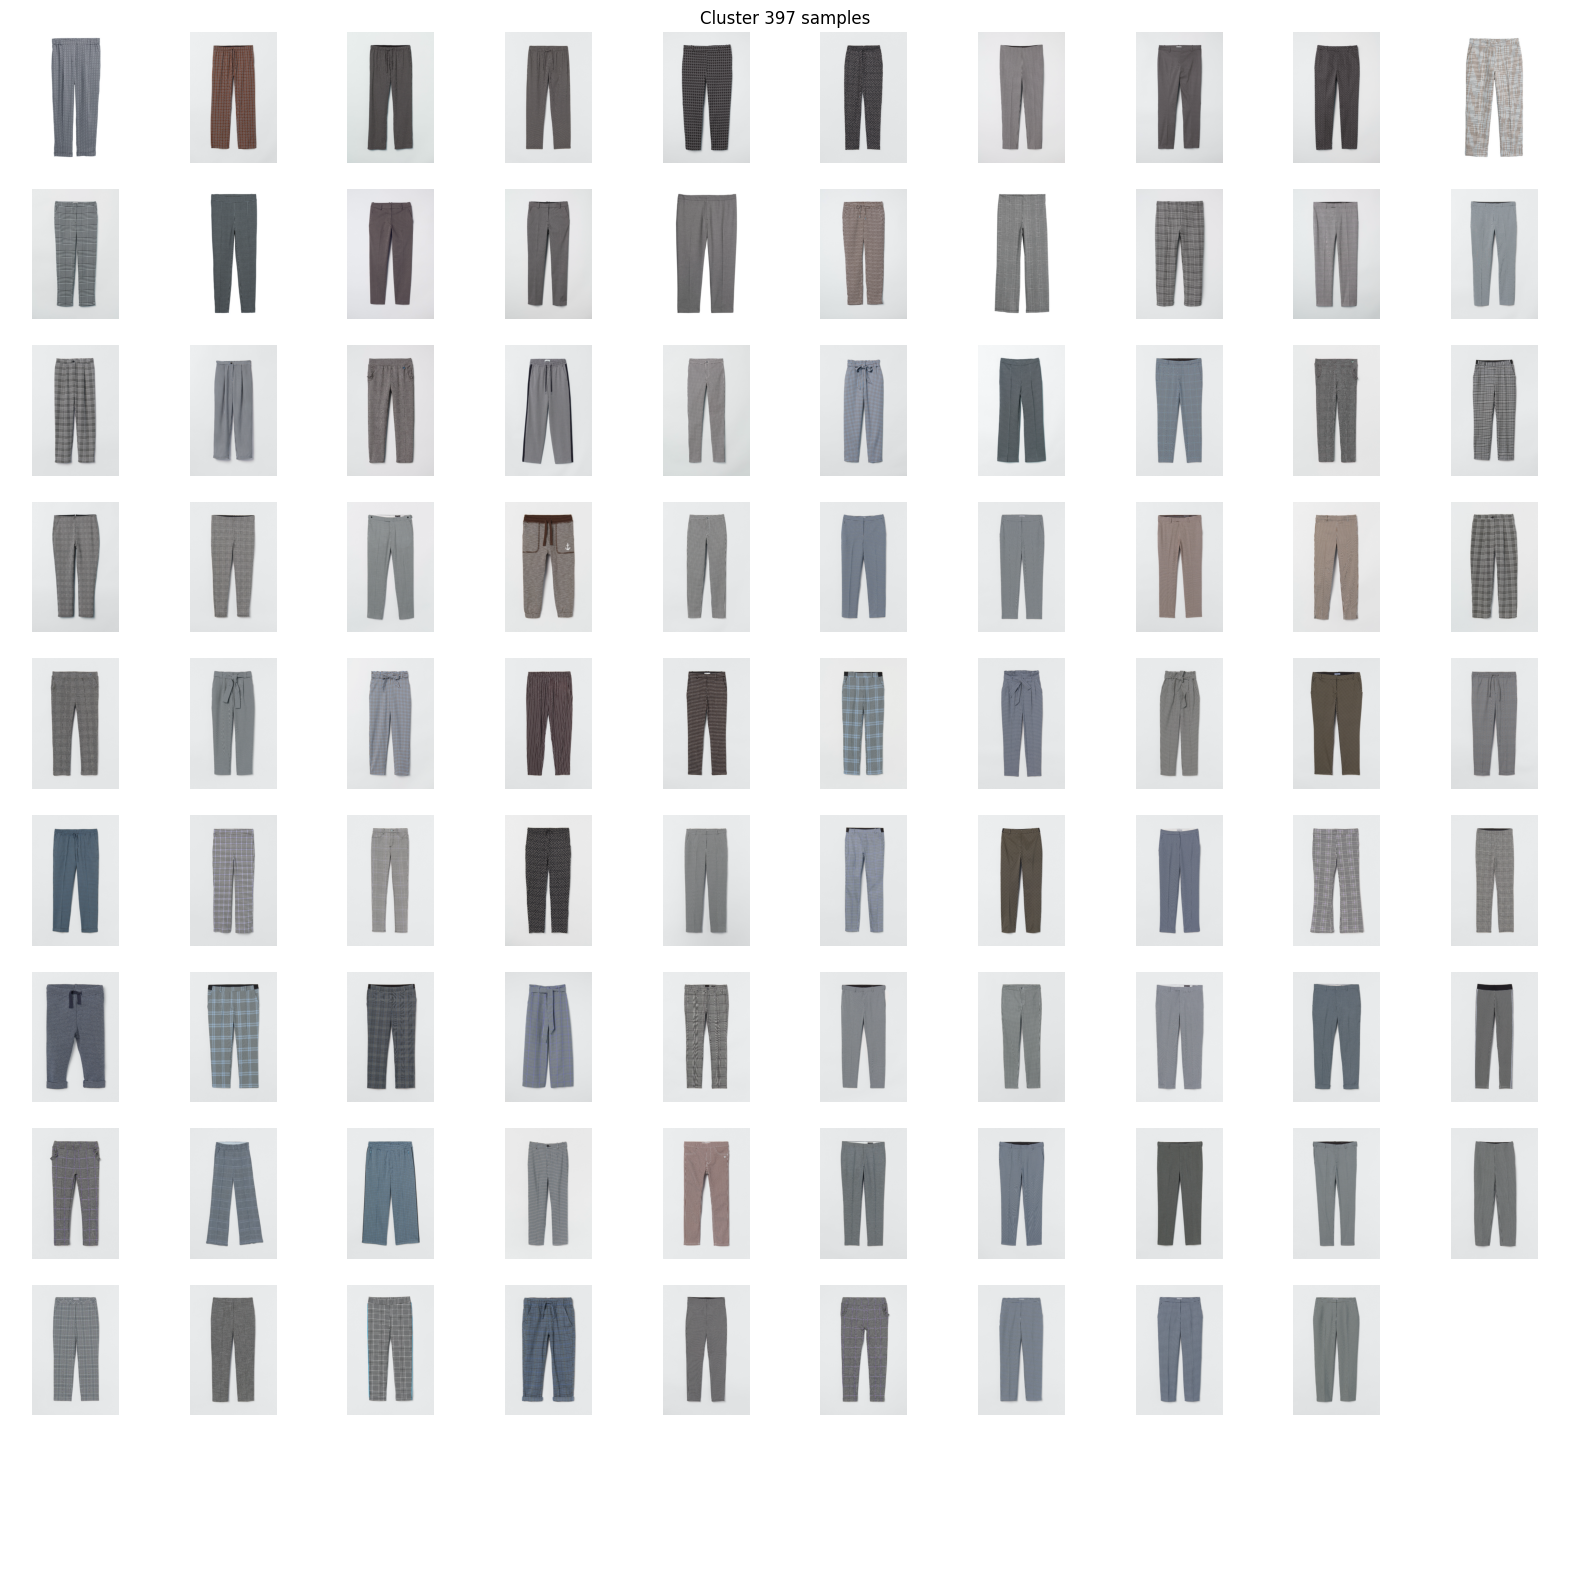

In [46]:
visualize_cluster(397,100)

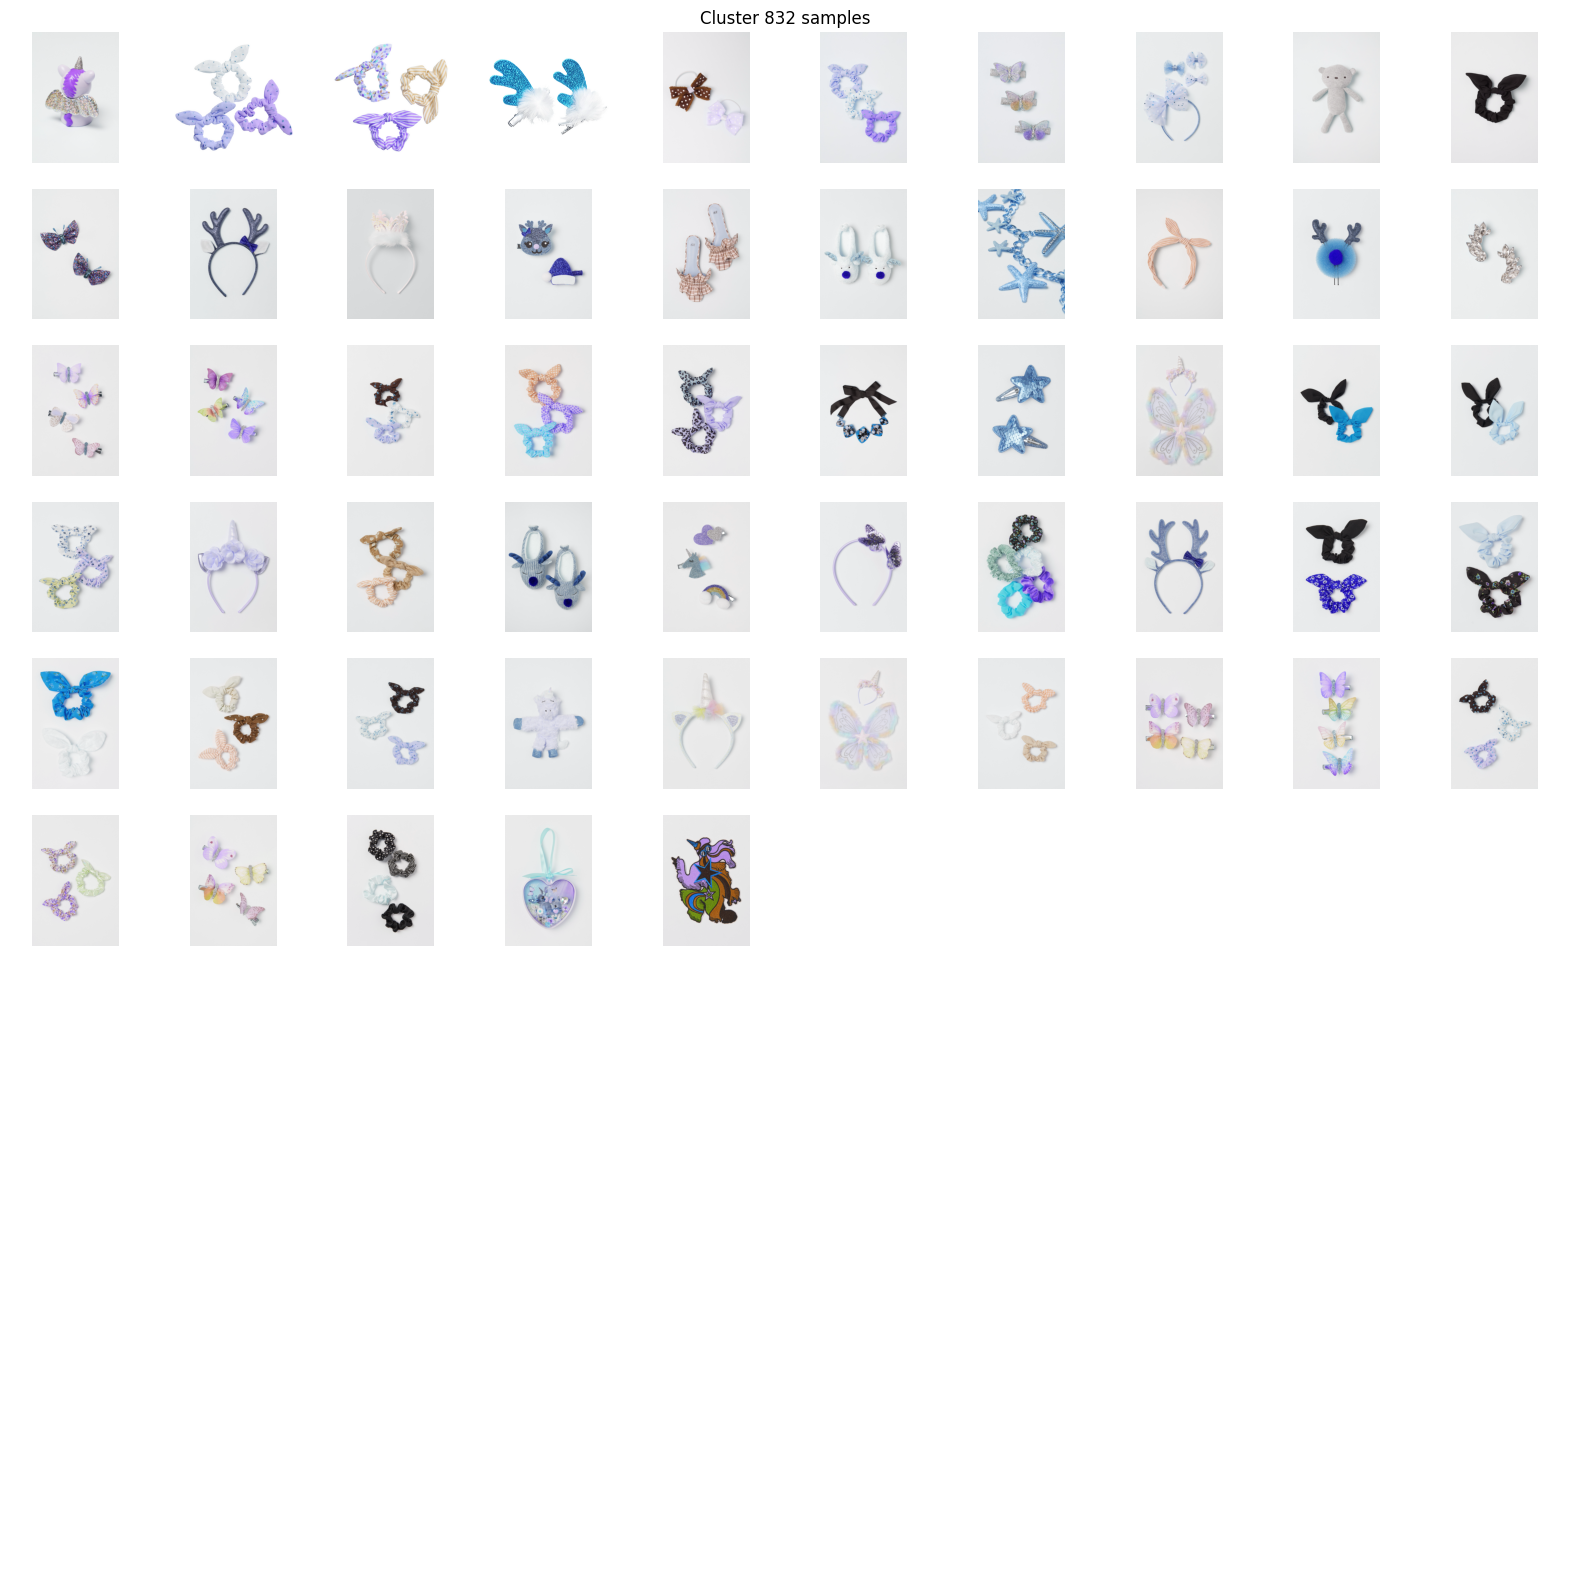

In [49]:
visualize_cluster(832,100)

In [53]:
# Saving clustering information in a file
with open('cluster_data.pkl', 'wb') as outfile:
    pickle.dump(cluster_data, outfile)